https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

## Ideas
- YearBuilt: there is a time effect here, we should check this futher and also check inflation adjustment
- build a seperate model for the samples where np.log(y) divcerges from normality
- seperate model per Neighbourhood
- salesPrice is almost always rounder to 1000's of 500's - we should also predict this way! didn't seem to change the score at all !! why? The log of the error is just too small to make a difference
- MSSubClass describes type of dwelling, and should be categorical, plus we might benefit from spliting it into several features
- MSZoning split into "Residential" true/false, and a numeric variable for density? seperate model for residential only?
- Condition1, Condition2 should be unioned. also Exterior2nd Exterior1st. 
- HouseStyle: extract stories numeric value, and "finished" flag?

## Notes

#### Basemenmt
A house either has a basement or it doesn't.  
When it does - we should have sensible values for all basement features.  
When it doesn't - they should all be "empty" features.  
There should not a mix of partial features.  
Analyzing the unusual samples from the base mode, we find many many samples with mixed features.  
So first, we need to choose a way to classifiy which samples have a basement and which don't, and then correct the features accordingly.

looking at the values, we determine that has_basement: TotalBsmtSF > 0


In [1]:
%load_ext autoreload
%autoreload 2

#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to
pd.options.display.max_rows = 999

color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats import norm, skew #for some statistics

import sys
sys.path.insert(0, "/Users/user/git/datasci")
from sci.metrics import rmse_score
from plots import *
import sci.features as scif
from sci.plots import *
import sci.learn as sci


Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('data/train.csv')
df_train = df_train.set_index("Id")
df_test = pd.read_csv('data/test.csv')
df_test = df_test.set_index("Id")

df = df_train
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

y = y/1000 # easier on the eyes

In [3]:
scif.df_summary(df_train)

,count,missing,percent,dtype,types,uniq,values,freq
PoolQC,7,1453,99.5205,object,str,3,"Ex, Fa, Gd","'Gd':3, 'Ex':2, 'Fa':2..."
MiscFeature,54,1406,96.3014,object,str,4,"Gar2, Othr, Shed, TenC","'Shed':49, 'Gar2':2, 'Othr':2, 'TenC':1..."
Alley,91,1369,93.7671,object,str,2,"Grvl, Pave","'Grvl':50, 'Pave':41..."
Fence,281,1179,80.7534,object,str,4,"GdPrv, GdWo, MnPrv, MnWw","'MnPrv':157, 'GdPrv':59, 'GdWo':54, 'MnWw'..."
FireplaceQu,770,690,47.2603,object,str,5,"Ex, Fa, Gd, Po, TA","'Gd':380, 'TA':313, 'Fa':33, 'Ex':24, 'Po':..."
LotFrontage,1201,259,17.7397,float64,float,110,"21.0, 24.0, 30.0, 32.0, 33.0, 34.0, 35.0, ...","'60.0':143, '70.0':70, '80.0':69, '50.0':5..."
GarageYrBlt,1379,81,5.5479,float64,float,97,"1900.0, 1906.0, 1908.0, 1910.0, 1914.0, ...","'2005.0':65, '2006.0':59, '2004.0':53, '20..."
GarageCond,1379,81,5.5479,object,str,5,"Ex, Fa, Gd, Po, TA","'TA':1326, 'Fa':35, 'Gd':9, 'Po':7, 'Ex':2..."
GarageType,1379,81,5.5479,object,str,6,"2Types, Attchd, Basment, BuiltIn, ...","'Attchd':870, 'Detchd':387, 'BuiltIn':88, ..."
GarageFinish,1379,81,5.5479,object,str,3,"Fin, RFn, Unf","'Unf':605, 'RFn':422, 'Fin':352..."


In [9]:
scif.df_summary(df_test)

,count,missing,percent,dtype,uniq,values,freq
PoolQC,3,1456,99.7944,object,2,"Ex, Gd","'Ex':2, 'Gd':1..."
MiscFeature,51,1408,96.5045,object,3,"Gar2, Othr, Shed","'Shed':46, 'Gar2':3, 'Othr':2..."
Alley,107,1352,92.6662,object,2,"Grvl, Pave","'Grvl':70, 'Pave':37..."
Fence,290,1169,80.1234,object,4,"GdPrv, GdWo, MnPrv, MnWw","'MnPrv':172, 'GdPrv':59, 'GdWo':58, 'MnWw'..."
FireplaceQu,729,730,50.0343,object,5,"Ex, Fa, Gd, Po, TA","'Gd':364, 'TA':279, 'Fa':41, 'Po':26, 'Ex':..."
LotFrontage,1232,227,15.5586,float64,115,"21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, ...","'60.0':133, '80.0':68, '70.0':63, '50.0':6..."
GarageYrBlt,1381,78,5.3461,float64,97,"1895.0, 1896.0, 1900.0, 1910.0, 1915.0, ...","'2005.0':77, '2007.0':66, '2006.0':56, '20..."
GarageFinish,1381,78,5.3461,object,3,"Fin, RFn, Unf","'Unf':625, 'RFn':389, 'Fin':367..."
GarageQual,1381,78,5.3461,object,4,"Fa, Gd, Po, TA","'TA':1293, 'Fa':76, 'Gd':10, 'Po':2..."
GarageCond,1381,78,5.3461,object,5,"Ex, Fa, Gd, Po, TA","'TA':1328, 'Fa':39, 'Po':7, 'Gd':6, 'Ex':1..."


In [95]:
scif.df_comp(df_train.drop(["SalePrice"], axis=1), df_test, "train", "test")

Using TensorFlow backend.



has NaN mismatch train vs test:
Electrical: train has NaN values, but test does not

has NaN mismatch test vs train:
MSZoning: test has NaN values, but train does not
Utilities: test has NaN values, but train does not
Exterior1st: test has NaN values, but train does not
Exterior2nd: test has NaN values, but train does not
BsmtFinSF1: test has NaN values, but train does not
BsmtFinSF2: test has NaN values, but train does not
BsmtUnfSF: test has NaN values, but train does not
TotalBsmtSF: test has NaN values, but train does not
BsmtFullBath: test has NaN values, but train does not
BsmtHalfBath: test has NaN values, but train does not
KitchenQual: test has NaN values, but train does not
Functional: test has NaN values, but train does not
GarageCars: test has NaN values, but train does not
GarageArea: test has NaN values, but train does not
SaleType: test has NaN values, but train does not

dtype mismatch:
BsmtFinSF1: train dtype is int64, but test dtype is float64
BsmtFinSF2: train dtype

Skewness: 1.882876
Kurtosis: 6.536282


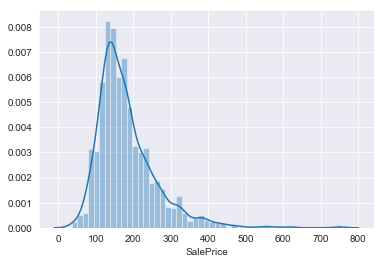

In [10]:
plot_dist(y)

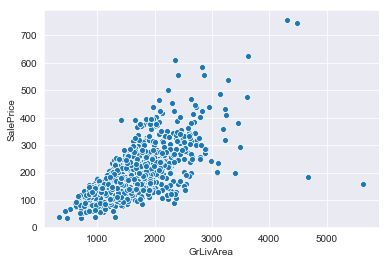

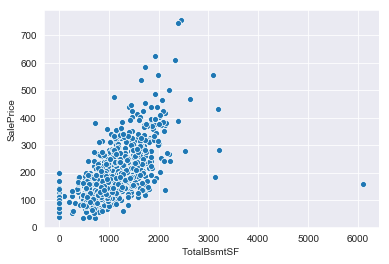

In [11]:
plot_scatter(X['GrLivArea'], y)
plot_scatter(X['TotalBsmtSF'], y)

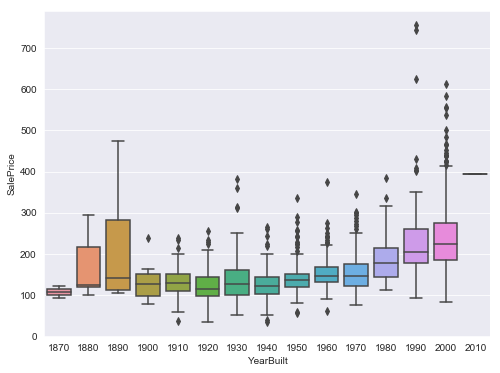

In [66]:
decade = (X['YearBuilt']/10).astype(int)*10
plot_boxplot(decade, y, figure=True)


missing    690
Gd         380
TA         313
Fa          33
Ex          24
Po          20
Name: FireplaceQu, dtype: int64

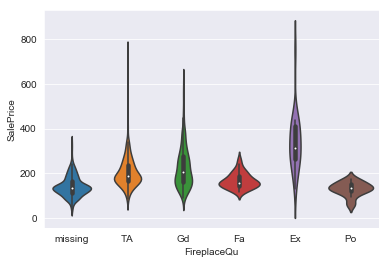

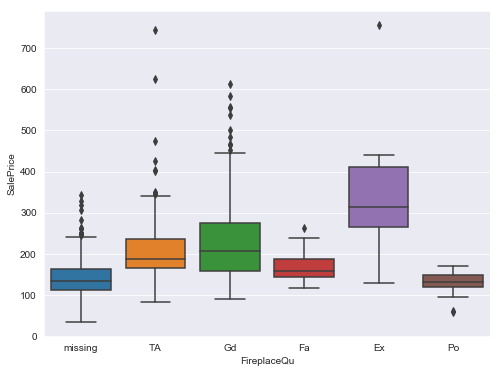

In [96]:
f = 'FireplaceQu'
v = X[f].fillna('missing')
sns.violinplot(v, y)
plot_boxplot(v, y, figure=True)
# plt.figure()
# plt.hist(X[f])
v.value_counts()


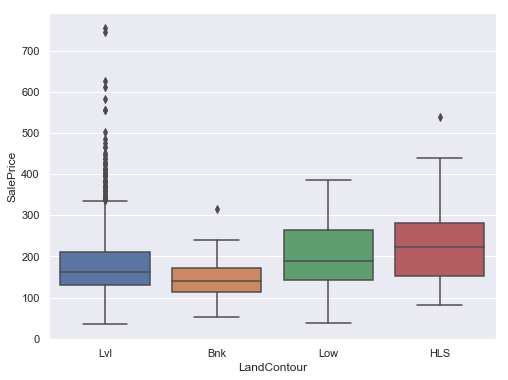

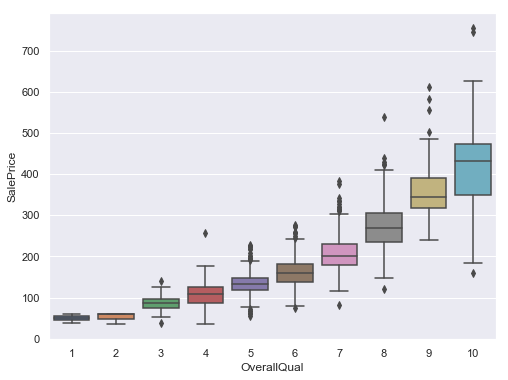

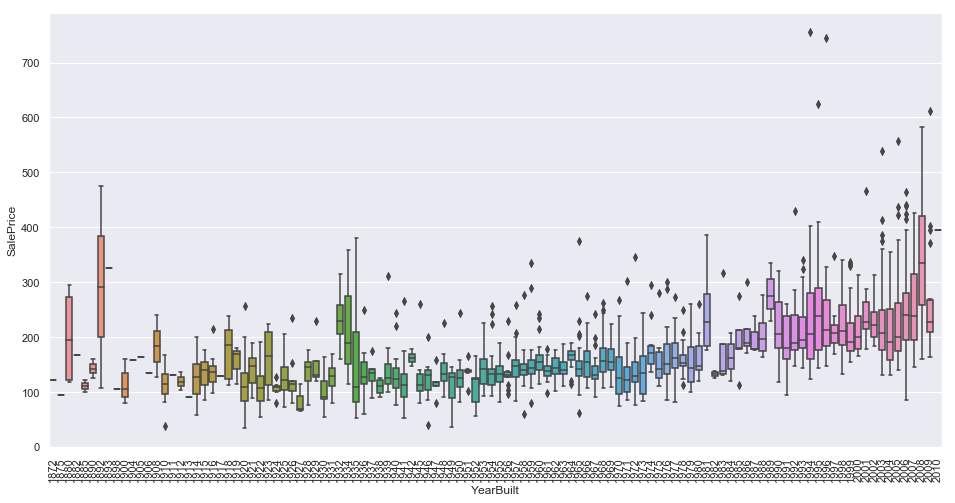

In [114]:
plot_boxplot(X['OverallQual'], y)
plot_boxplot(X['YearBuilt'], y, figsize=(16, 8))
plt.xticks(rotation=90);

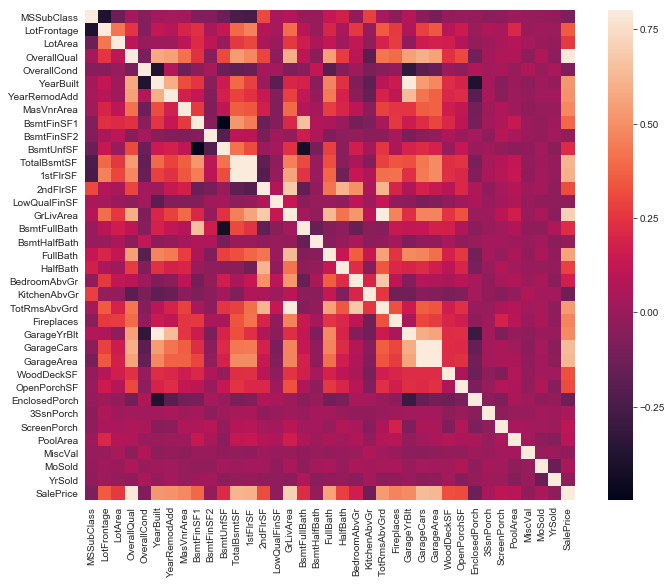

In [46]:
plot_corr_matrix(df)

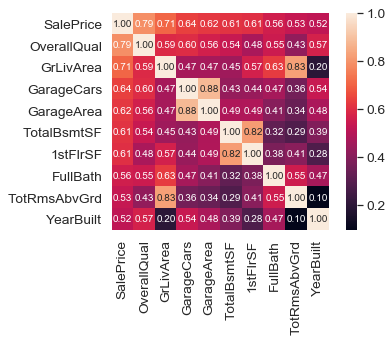

In [48]:
plot_corr_matrix_top(df)

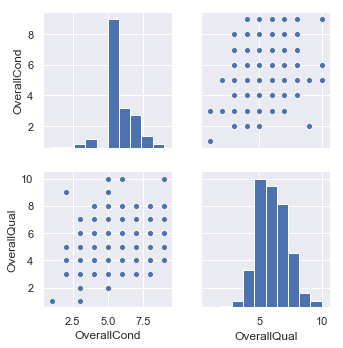

In [132]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
cols = ['OverallCond', 'OverallQual']

plot_pairplot(df, cols)

In [94]:
show_missing_data(df_test)

,Total,Percent
PoolQC,1456,99.7944
MiscFeature,1408,96.5045
Alley,1352,92.6662
Fence,1169,80.1234
FireplaceQu,730,50.0343
LotFrontage,227,15.5586
GarageCond,78,5.3461
GarageFinish,78,5.3461
GarageYrBlt,78,5.3461
GarageQual,78,5.3461


In [60]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


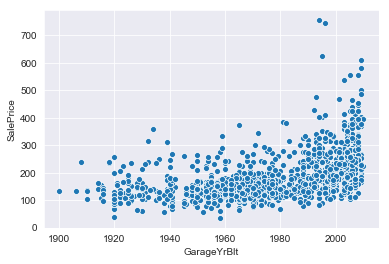

In [93]:
plot_scatter(X['GrLivArea'], y)

## Normality

Skewness: 1.880941
Kurtosis: 6.509812
Skewness: 0.121210
Kurtosis: 0.802656


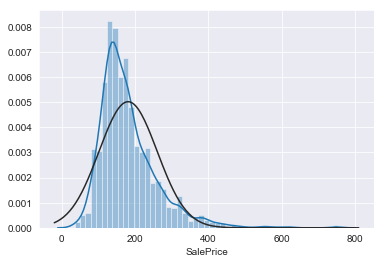

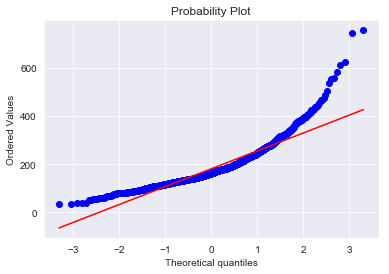

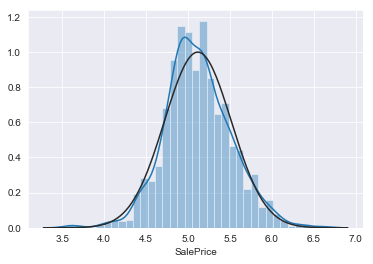

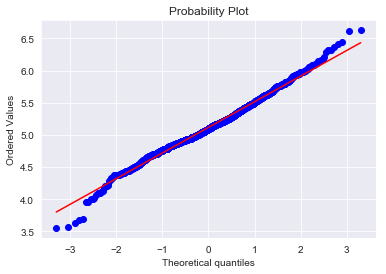

In [48]:
import scipy.stats
def plot_normality(x, figure=True):
    print("Skewness: %f" % scipy.stats.skew(x))
    print("Kurtosis: %f" % scipy.stats.kurtosis(x))
    plt.figure()
    sns.distplot(x, fit=norm);
    fig = plt.figure()
    res = stats.probplot(x, plot=plt)

plot_normality(y)
plot_normality(np.log(y)) # postiive skew is often reduced with log transform


Skewness: 0.000158
Kurtosis: 0.670501


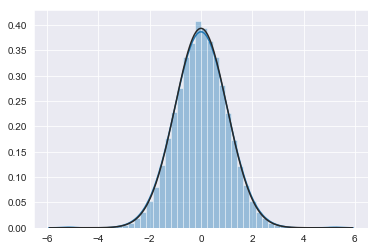

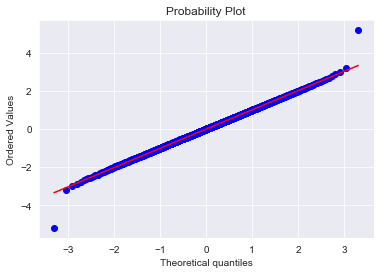

In [82]:
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

tr = PowerTransformer('yeo-johnson')
tr = PowerTransformer('box-cox')
tr = QuantileTransformer(output_distribution='normal', n_quantiles=10000)

z = tr.fit_transform(y.to_frame())
z = z[:, 0]

# tr = PowerTransformer('yeo-johnson')
# z = tr.fit_transform(y.to_frame())
# z = z[:, 0]

# z = tr.inverse_transform(z.reshape(-1, 1))
# z = z[:, 0]

# z = np.log(y)
plot_normality(z)

No handles with labels found to put in legend.


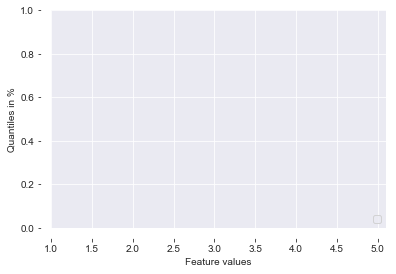

In [87]:

N_QUANTILES = 10000
FEAT_VAL = 3.0
def plot_transform_feat_val(ax, transformer, title):
    """Plot the mapping function as well as a specific feature value."""
    ref = np.linspace(0, 1, num=N_QUANTILES)

    ax.plot(transformer.quantiles_, ref)
#     ax.scatter([FEAT_VAL], [transformer.transform(FEAT_VAL)], c='r',
#                label=r'$f({0}) = {1:.2f}$'.format(
#                    FEAT_VAL,
#                    np.ravel(transformer.transform(FEAT_VAL))[0]))
    ax.set_xlabel('Feature values')
    ax.set_ylabel('Quantiles in %')
    ax.set_title(title)
    ax.legend(loc=4)
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlim([1, 5.1])
    ax.set_ylim([0, 1])
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    
plt.figure()
plot_transform_feat_val(plt.gca(), tr, "")

skew: 0.12121036730137079
lam: 0.7889241706670747
skew: 0.06252532668488879
Skewness: 0.062525
Kurtosis: 0.833391


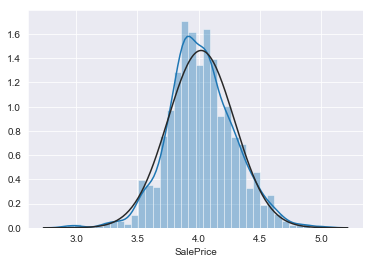

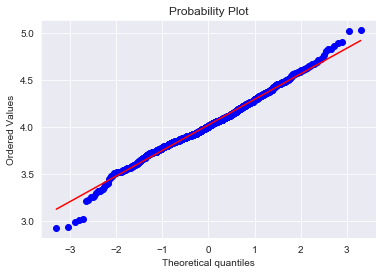

In [63]:
# plot_normality(np.power(y, 1/200000)) # postiive skew is often reduced with log transform
z = np.log(y)
# z = z - z.mean()
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

print('skew:', skew(z))
lam = 0.15
lam = boxcox_normmax(z)
print('lam:', lam)
z = boxcox1p(z, lam)
print('skew:', skew(z))

plot_normality(z.dropna())


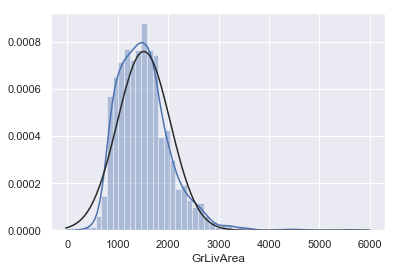

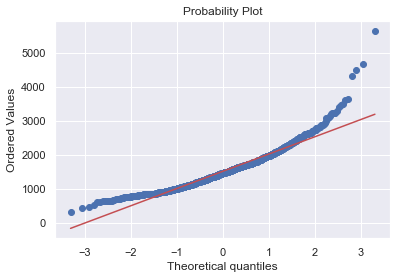

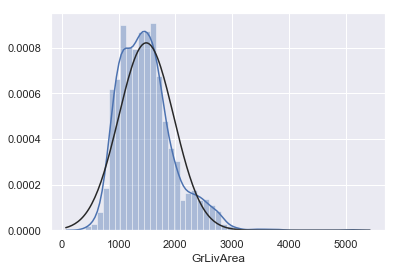

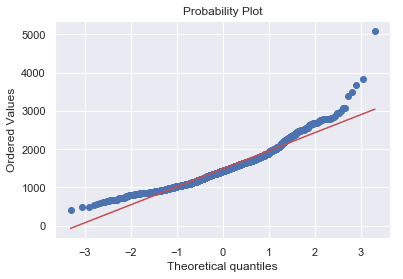

In [97]:
plot_normality(X['GrLivArea'], figure=False)
plot_normality(df_test['GrLivArea'], figure=False)
# plot_normality(np.log(X['GrLivArea'])) # postiive skew is often reduced with log transform

In [76]:
# df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
# df_train = df_train.drop(df_train[df_train.index == 1299].index)
# df_train = df_train.drop(df_train[df_train.index == 524].index)

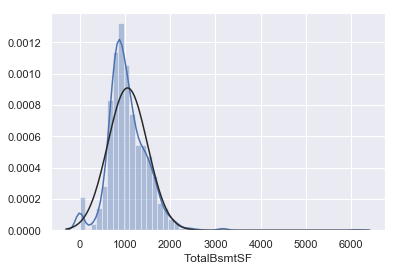

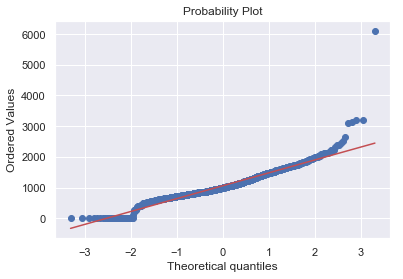

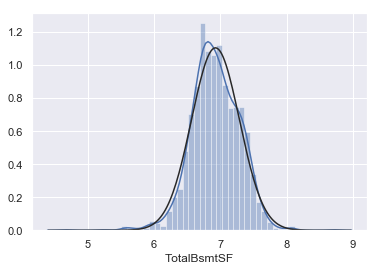

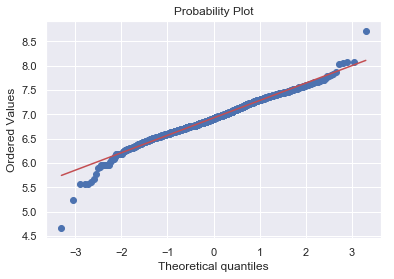

In [78]:
# in this case the zero values prevent us from making a log transform
# so we need to add a new features only for the log_transformed values
plot_normality(X['TotalBsmtSF'])
non_zero = X['TotalBsmtSF'][X['TotalBsmtSF']>0]
plot_normality(np.log(non_zero)) # postiive skew is often reduced with log transform

## homoscedasticity

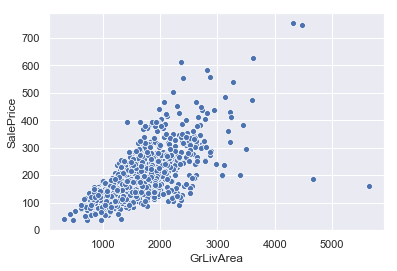

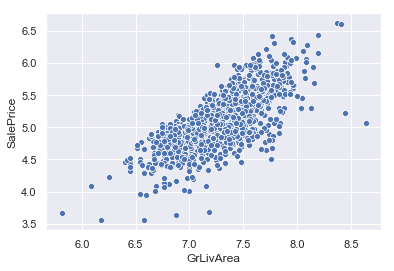

In [81]:
# log transformation help with homoscedasticity
plot_scatter(X['GrLivArea'], y)
plot_scatter(np.log(X['GrLivArea']), np.log(y))

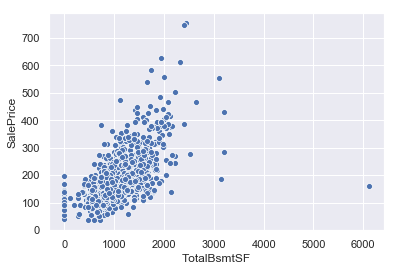

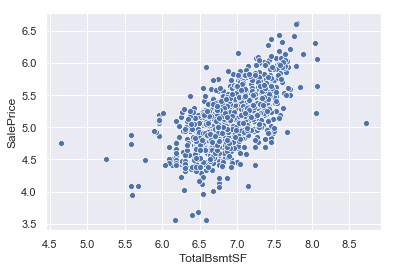

In [83]:
# log transformation help with homoscedasticity
plot_scatter(X['TotalBsmtSF'], y)
plot_scatter(np.log(X['TotalBsmtSF']), np.log(y))

## crosstab related features

In [92]:
df = df_train
display(pd.crosstab(df['SaleCondition'], df['SaleType']))

SaleType,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
SaleCondition,,,,,,,,,
Abnorml,24,1,0,2,1,0,0,3,70
AdjLand,0,0,0,0,0,0,0,0,4
Alloca,0,0,0,0,0,0,0,0,12
Family,0,1,0,0,0,0,0,0,19
Normal,19,2,2,6,4,5,0,0,1160
Partial,0,0,0,1,0,0,122,0,2


## Missings in subsets of features

In [84]:
df = df_train
cols = [x for x in df.columns if 'Garage' in x]
df = df[cols]
scif.df_summary(df, missing_only=False)

,count,missing,percent,dtype,uniq,values,freq
GarageType,1379,81,5.5479,object,6,"2Types, Attchd, Basment, BuiltIn, ...","'Attchd':870, 'Detchd':387, 'BuiltIn':88, ..."
GarageYrBlt,1379,81,5.5479,float64,97,"1900.0, 1906.0, 1908.0, 1910.0, 1914.0, ...","'2005.0':65, '2006.0':59, '2004.0':53, '20..."
GarageFinish,1379,81,5.5479,object,3,"Fin, RFn, Unf","'Unf':605, 'RFn':422, 'Fin':352..."
GarageQual,1379,81,5.5479,object,5,"Ex, Fa, Gd, Po, TA","'TA':1311, 'Fa':48, 'Gd':14, 'Ex':3, 'Po':3..."
GarageCond,1379,81,5.5479,object,5,"Ex, Fa, Gd, Po, TA","'TA':1326, 'Fa':35, 'Gd':9, 'Po':7, 'Ex':2..."
GarageCars,1460,0,0.0000,int64,5,"0, 1, 2, 3, 4","'2':824, '1':369, '3':181, '0':81, '4':5..."
GarageArea,1460,0,0.0000,int64,441,"0, 160, 164, 180, 186, 189, 192, 198, ...","'0':81, '440':49, '576':47, '240':38, '484'..."


## Base multi-variate 'mode', and unusual samples from 'mode'

In [ ]:
base_mode = show_most_common_multi_col_mode(df_train, col_contains="Bsmt")
display(base_mode[["mode"]].T)
unusual = show_unusual_rows_from_base_mode(df_train, col_contains="Bsmt")
display(unusual['_unusual'].value_counts())
unusual.query('_unusual == 1')